In [1]:
# Plot confidence in dog against alpha value

import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

from keras import utils
from sklearn.preprocessing import LabelEncoder

In [2]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)

random_sample = 1

In [3]:
# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(253, 253)

In [4]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['no' 'yes']


In [5]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

In [6]:
# The data augmentation to do. This applies a random horizontal flip and a random tilt.
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation((-0.3, 0.3)),
])

def get_balance_iters(label):
    # Returns a value for over-sampling if balancing the data
    if label[0] == "no":
        return 1
    else:
        return 1


In [7]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Preparing testing data


In [8]:
# IMPORTANT

MUBA_BALANCE = False # If true data will be oversampled to create balanced classes
AUGMENT = False # Recommended True if balancing

MIX_UP_LOOPS = 100 # How many times to create mix up images per image

In [9]:
all_lams= []
all_new_labels= []
all_mixed_up_images = []


for img, label in zip(images,labels):

    if AUGMENT:
        img = data_augmentation(img)

    if MUBA_BALANCE:
        balance_iters = get_balance_iters(label)
    else:
        balance_iters = 1

    for i in range(MIX_UP_LOOPS):
        for j in range(balance_iters):

            # Get index of label
            i_array = np.where(label == 1)[0]

            while len(i_array) != 2:

                # Get a new mixup image
                mixup_idx = random.randint(0, len(labels)-1)
                mixup_label = labels[mixup_idx]
                mixup_i = np.where(mixup_label == 1)[0][0]

                # Check mixup image has a different label
                if mixup_i not in i_array:
                    # Add index to i_array 
                    i_array = np.append(i_array, mixup_i)

                    #Read image
                    mixup_image = images[mixup_idx]
                    if AUGMENT:
                        mixup_image = data_augmentation(mixup_image)

                    # Mixup images
                    lam = np.random.rand()
                    new_img = lam * img + (1 - lam) * mixup_image   
        
                    new_label = lam * label + (1 - lam) * mixup_label
                    #Append images
                    all_lams.append(lam)
                    all_new_labels.append(new_label)
                    all_mixed_up_images.append(new_img)


In [10]:
model = keras.models.load_model("best_simple_model_2.h5")

2/2 [==============================] - 4s 589ms/step
Percentage Correct = 86.84%


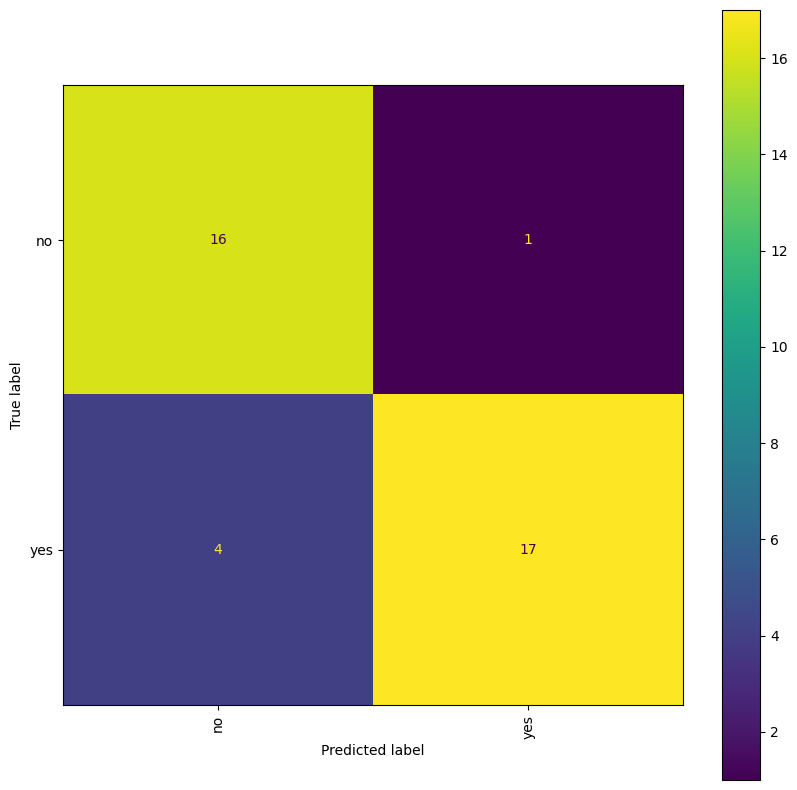

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get Predictions
result = model.predict(np.stack(images))
pred_array = [[0,1,2][np.argmax(individual_result)] for individual_result in result]

simple_true = 0
for pred, label in zip(pred_array, labels):
    if np.where(label == 1)[0][0] == pred:
        simple_true += 1

print(f"Percentage Correct = {round((simple_true * 100)/len(labels),2)}%")

y_actual = []
for pred in y_test:    
    if pred[0] == 1:
        y_actual.append(0)
    if pred[1] == 1:
        y_actual.append(1)
    


fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
        y_actual,
        pred_array,
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        display_labels = ["no","yes"]
)

plt.show()

In [12]:
lams = [lam[0] for lam in all_new_labels] #proportion no

Text(0, 0.5, 'N')

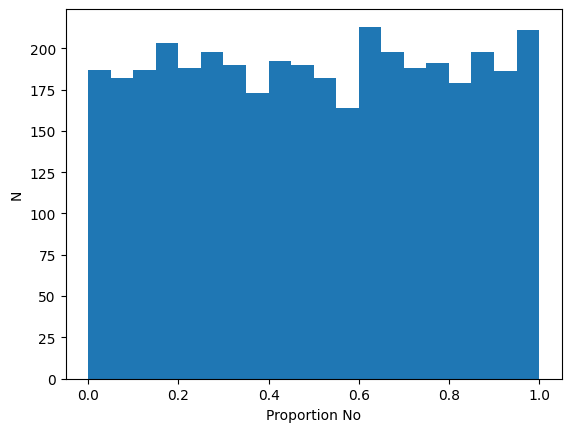

In [13]:
plt.hist(lams,bins=20)
plt.xlabel("Proportion No")
plt.ylabel("N")



In [14]:
correct_lams = []
incorrect_lams = []
incorrect_proper = []
correct_proper = []


result = model.predict(np.stack(all_mixed_up_images))

prediction_proper = result
prediction = [[0,1][np.argmax(individual_result)] for individual_result in result]




119/119 [==============================] - 240s 2s/step


In [15]:
test_results = model.predict(np.stack(images))

2/2 [==============================] - 3s 500ms/step


In [16]:
test_lams = [lam[0] for lam in test_results]
test_labels = [label[0] for label in labels]

In [17]:
prediction_proper = [pred[0] for pred in prediction_proper]

In [18]:
for pred, pred_prop ,label,lam in zip(prediction, prediction_proper, all_new_labels, lams):
        if pred != [0,1][np.argmax(label)]:
            incorrect_lams.append(lam)
            incorrect_proper.append(pred_prop)
        else:
            correct_lams.append(lam)
            correct_proper.append(pred_prop)

Text(0.35, 0.72, 'Mean: 0.52')

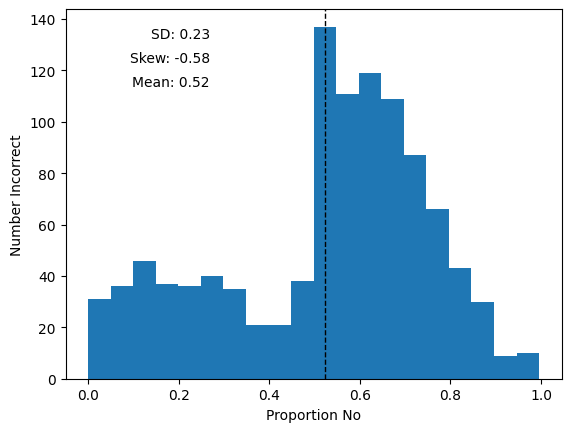

In [19]:
from scipy.stats import skew


plt.hist(incorrect_lams,bins=20)
plt.axvline(np.mean(incorrect_lams), color='k', linestyle='dashed', linewidth=1)
plt.xlabel("Proportion No")
plt.ylabel("Number Incorrect")
plt.text(0.35,0.82,f"SD: {round(np.std(incorrect_lams),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
plt.text(0.35,0.77,f"Skew: {round(skew(incorrect_lams),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")
plt.text(0.35,0.72,f"Mean: {round(np.mean(incorrect_lams),2)}",transform=plt.gcf().transFigure, horizontalalignment = "right")

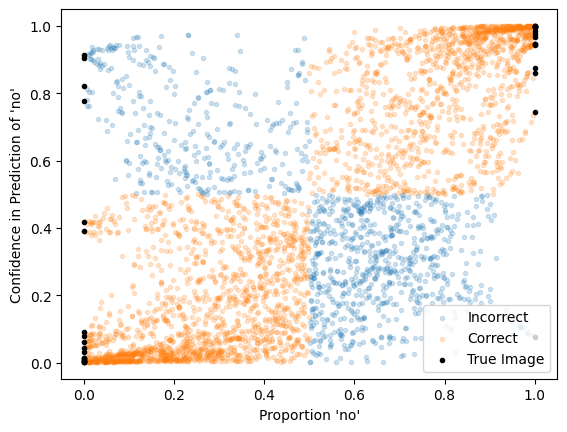

In [20]:
plt.scatter(incorrect_lams,incorrect_proper, alpha = 0.2, label = "Incorrect", marker = '.')
plt.scatter(correct_lams,correct_proper, alpha = 0.2, label = "Correct", marker = ".")
plt.scatter(test_labels,test_lams, color = "black", label = "True Image", marker = ".")
plt.xlabel("Proportion 'no'")
plt.ylabel("Confidence in Prediction of 'no'")
plt.legend()

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_9336\2400700220.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Text(0, 0.5, "Confidence in Prediction of 'no'")

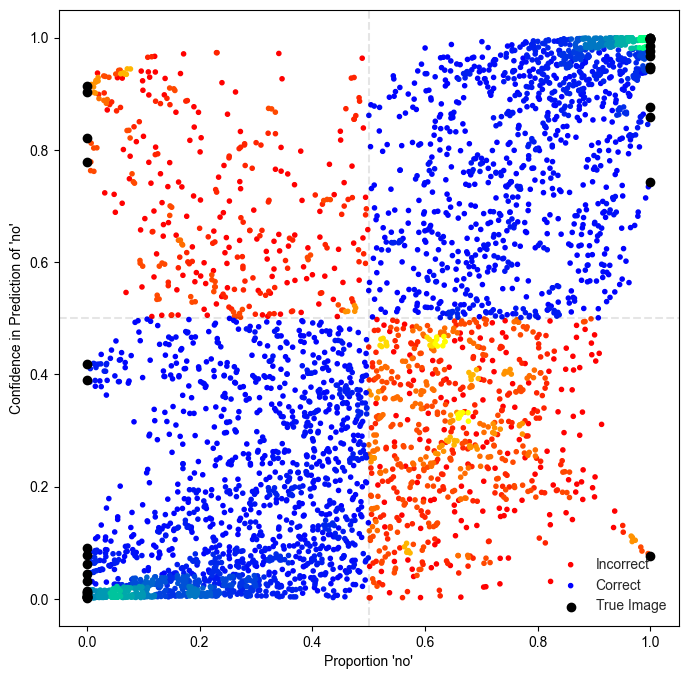

<Figure size 800x800 with 0 Axes>

In [21]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.axhline(y=0.5, color='black', linestyle='--', alpha = 0.1)
ax.axvline(x=0.5, color='black', linestyle='--', alpha = 0.1)

#histogram definition
bins = [50, 50] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(incorrect_lams, incorrect_proper, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(incorrect_lams,incorrect_proper)])
idx = z.argsort()
x2, y2, z2 = np.array(incorrect_lams)[idx], np.array(incorrect_proper)[idx], np.array(z)[idx]

fig = plt.figure(figsize=(8,8))
plt.style.use('seaborn-white')

ax.scatter(x2, y2, c=z2, cmap='autumn', marker='.', label = "Incorrect")  

# histogram the data
hh, locx, locy = np.histogram2d(correct_lams, correct_proper, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(correct_lams,correct_proper)])
idx = z.argsort()
x2, y2, z2 = np.array(correct_lams)[idx], np.array(correct_proper)[idx], np.array(z)[idx]

ax.scatter(x2, y2, c=z2, cmap='winter', marker='.', label = "Correct") 

ax.scatter(test_labels,test_lams, color = "black", label = "True Image")

ax.legend()
ax.set_xlabel("Proportion 'no'")
ax.set_ylabel("Confidence in Prediction of 'no'")